In [ ]:
Problem: Increase in loan default rates --> Revenue/customer loss for clients --> loss of creditpr clients for CO

Investigative Questions: How do you ensure that customers can/will pay their loans? Can we do this?

In [1]:
## Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from scipy import stats
from scipy.stats import pearsonr
from pandas_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

%matplotlib inline

## ML-related, COmment Out as Unnecessary
#from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.metrics import accuracy_score, classification_report
#from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
#from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree, export_text
#from scipy.stats import kendalltau
#import plotly as py
#import plotly.graph_objects as go

In [2]:
# Loading dataset containing cleaned-original PLUS my own fields derived earlier
# Will switch to Cleaned-original from C2T1 if necessary
data = pd.read_csv("C2-orig-plus-derived.csv").drop(columns=['Unnamed: 0'])
data.info()
#data.isnull().any() ## Confirm no nulls left in from prior stages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         30000 non-null  int64  
 1   LIMIT_BAL                  30000 non-null  int64  
 2   MARRIAGE                   30000 non-null  int64  
 3   AGE                        30000 non-null  int64  
 4   PAY_1                      30000 non-null  int64  
 5   PAY_2                      30000 non-null  int64  
 6   PAY_3                      30000 non-null  int64  
 7   PAY_4                      30000 non-null  int64  
 8   PAY_5                      30000 non-null  int64  
 9   PAY_6                      30000 non-null  int64  
 10  BILL_AMT1                  30000 non-null  int64  
 11  BILL_AMT2                  30000 non-null  int64  
 12  BILL_AMT3                  30000 non-null  int64  
 13  BILL_AMT4                  30000 non-null  int

In [3]:
## Discretized Age Bins RUN ONCE
#sns.histplot(data=data['AGE']) ## Noone <20, minimal 60+

## Test four different 'bin methodologies'
#Don't use retbins b/c returns tuple instead of integer series
AgeBin1 = pd.qcut(data['AGE'], q=5, labels=False) ##Quintiles
AgeBin2 = pd.cut(data['AGE'], bins=[19,29,39,49,59,69,100], labels=False,
                 ordered=True) ## Decade range, i.e. 'twenties'
AgeBin3 = pd.cut(data['AGE'], bins=[18,24,39,54,100], labels=False, 
                 ordered=True) ## Typical TV rating bins 18-24,25-39,40-54,55+
AgeBin4 = pd.qcut(data['AGE'], q=20, labels=False)
#print(AgeBin3.isnull().any()) ## All bins appear proper shape without NaN
data=pd.concat([data,AgeBin1.rename('AgeBin1'),AgeBin2.rename('AgeBin2'),
                AgeBin3.rename('AgeBin3'), AgeBin4.rename('AgeBin4')], axis=1)

## Comparing Bin methodologies against def_next_default
corr=data[['AgeBin1','AgeBin2','AgeBin3','AgeBin4','def_next_default']].corr()
print(corr) ## AgeBin2 correlates with def_next_default 0.014 vs. ~0.006 for methods 1, 3, 4
## --> Proceed with AgeBin2 (decade ranges) for further analysis

                   AgeBin1   AgeBin2   AgeBin3   AgeBin4  def_next_default
AgeBin1           1.000000  0.902910  0.815919  0.980687          0.006395
AgeBin2           0.902910  1.000000  0.864761  0.933474          0.014722
AgeBin3           0.815919  0.864761  1.000000  0.854041          0.006360
AgeBin4           0.980687  0.933474  0.854041  1.000000          0.006197
def_next_default  0.006395  0.014722  0.006360  0.006197          1.000000


In [4]:
## Subset features to new Summary df, reducing columns for easier analysis

Summary=data[['ID','def_next_default','LIMIT_BAL','AgeBin2','SEX_female','Debt_UsageAVG','Total_Bill','Total_Paid',
            'Net_Borrow', 'ED_CollegePlus','PrevRel','EvBehind','AvgPayTime']].copy().astype(int)

## Education - Ordinal vs. One-hot vs. 'My' Encoding 
## Could not get Encoding functions working (see code blocks & error summary below)
## Proceeded with own custom mapping of 'EdRank'

## Dummy variable encoding already performed, revert to orig dataset for ordinal/label functions
orig = pd.read_csv("C2T1-Cleaned.csv")
#orig.info()
orig['EDUCATION']=orig['EDUCATION'].astype(object)

#print(orig['LIMIT_BAL'].groupby(orig['EDUCATION']).describe())
#print(orig['AGE'].groupby(orig['EDUCATION']).describe())
# -->'Other' education appears distinctive versus high_school, so maintain separate category instead of combining.

EdRanks = {'graduate school':3,
          'university':2,
          'other':1,
          'high school':0}
orig['EdRank']=orig['EDUCATION'].map(EdRanks)

#sns.histplot(data=EdRank) # ~14K university and ~10K grad school
#sns.histplot(data=orig['EDUCATION'])
#print(orig['EdRank'].describe())

## Label and Ordinal Encoding
#encoder = LabelEncoder()
#EdLevel = encoder.fit_transform(orig['EDUCATION'])
#sns.histplot(data=orig['EDUCATION'])
#sns.histplot(data=EdLevel)
##LabelEncoder categorized university as 3.0 and graduate school as 0, not exactly reflective, so disregard

#encoder2 = OrdinalEncoder()
#print(orig.info())
#EdLevel2 = encoder2.fit_transform((orig['EDUCATION']).reshape(-1,1)) 
## Produces error  "Expected 2D array, got 1D array instead"
## When append .reshape(-1,1) produces error "Series object has no attribute reshape"

In [5]:
## Append EdRank to overall and summary dataframe
## RUN ONCE per Kernel start then comment out

#Summary=pd.concat([Summary,orig['EdRank']], axis=1)
#data=pd.concat([data,orig['EdRank']], axis=1)

#print(Summary.info())
#print(data.info())


In [ ]:
## Does EdRank correlate any closer than my 'ED_CollegePlus' boolean categorical? --> Yes
#sns.heatmap(Summary.corr(),vmin=-1, vmax=1, cmap='BrBG', center=0);
#print(Summary.corr().sort_values(['def_next_default'], ascending=False))
#EdRank -0.04 correlation with def_next_default vs. -.016 for ED_CollegePlus 
#EdRank correlation to LIMIT_BAL is 0.22 vs. .13 for ED_CollegePlus

In [6]:
## Functions to be called later

def get_redundant_pairs(data):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = data.columns
    for i in range(0, data.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(Summary, 20))

def correlation_table(data,target_column):
    data_num = data.select_dtypes(include=['int','float'])
    corr_df = pd.DataFrame(data_num.corrwith(data_num[target_column]),columns=['Correlation']).dropna()
    corr_df['ABS Correlation'] = abs(corr_df['Correlation'])
    corr_df.sort_values(by=['ABS Correlation'], ascending=False, inplace=True)
    print(corr_df)

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betai(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

def kendall_pval(x,y):
    return kendalltau(x,y)[1]
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

##Check for Multi-collinearity

def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

def removeMultiColl(data, vif_threshold = 5.0):
    for i in data.columns:
        if data[i].nunique() == 1:
            print(f"Dropping {i} due to just 1 unique value")
            data.drop(columns = i, inplace = True)
    drop = True
    col_list = list(data.columns)
    while drop == True:
        drop = False
        vif_list = Parallel(n_jobs = -1, verbose = 5)(delayed(variance_inflation_factor)(data[col_list].values, i) for i in range(data[col_list].shape[1]))
        max_index = vif_list.index(max(vif_list))
        if vif_list[max_index] > vif_threshold:
            print(f"Dropping column : {col_list[max_index]} at index - {max_index}")
            del col_list[max_index]
            drop = True
    print("Remaining columns :\n", list(data[col_list].columns))
    return data[col_list]

def multicollinearity_check(X, thresh=5.0):
    data_type = X.dtypes
    # print(type(data_type))
    int_cols = \
    X.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float16', 'float32', 'float64']).shape[1]
    total_cols = X.shape[1]
    try:
        if int_cols != total_cols:
            raise Exception('All the columns should be integer or float, for multicollinearity test.')
        else:
            variables = list(range(X.shape[1]))
            dropped = True
            print('''\n\nThe VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.\n\n''')
            while dropped:
                dropped = False
                vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in variables]
                print('\n\nvif is: ', vif)
                maxloc = vif.index(max(vif))
                if max(vif) > thresh:
                    print('dropping \'' + X.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                    # del variables[maxloc]
                    X.drop(X.columns[variables[maxloc]], 1, inplace=True)
                    variables = list(range(X.shape[1]))
                    dropped = True

            print('\n\nRemaining variables:\n')
            print(X.columns[variables])
            # return X.iloc[:,variables]
            return X
    except Exception as e:
        print('Error caught: ', e)
#correlation_table(Summary.drop(columns=['def_next_default'],inplace=True), Summary['def_next_default'])

Top Absolute Correlations
Total_Bill        Net_Borrow        0.987555
ED_CollegePlus    EdRank            0.888642
AgeBin2           PrevRel           0.450593
EvBehind          AvgPayTime        0.422624
def_next_default  EvBehind          0.352858
LIMIT_BAL         Total_Paid        0.352655
Total_Bill        Total_Paid        0.343906
LIMIT_BAL         Total_Bill        0.302044
                  AvgPayTime        0.275824
Net_Borrow        AvgPayTime        0.262049
LIMIT_BAL         Net_Borrow        0.256616
def_next_default  AvgPayTime        0.250756
Total_Bill        AvgPayTime        0.244699
LIMIT_BAL         EdRank            0.222762
AgeBin2           ED_CollegePlus    0.220537
                  EdRank            0.214497
LIMIT_BAL         EvBehind          0.214436
Total_Paid        Net_Borrow        0.191943
PrevRel           EdRank            0.172601
def_next_default  LIMIT_BAL         0.153520
dtype: float64


In [7]:
## Experiments with other derived boolean categorizations
## Not sure if will serve distinct ML purpose vs. just segmenting per queries?

## Var_Payer = Top X%ile based on std. dev within the range of Pay_1:Pay_6 codes
## Slow_Payer = Top %ile for AvgPaytime
## High_Lev = Top %ile for Debt_UsageAVG

## ED_CollegePlus = Boolean I'd created myself before learning about ranking, selects University OR graduate_school

thresh=.8 ## changable percentile threshold (i.e., .9 vs. 8)

data['Slow_Payer'] = data['AvgPayTime'].ge(data['AvgPayTime'].quantile(thresh, interpolation="lower")).astype(int)
data['High_Lev'] = data['Debt_UsageAVG'].ge(data['Debt_UsageAVG'].quantile(thresh, interpolation="lower")).astype(int)

### IMPORTANT - Run Once To This Point, then COmment Out

In [8]:
#Summary=pd.concat([Summary,data['Slow_Payer'],data['High_Lev']],axis=1)

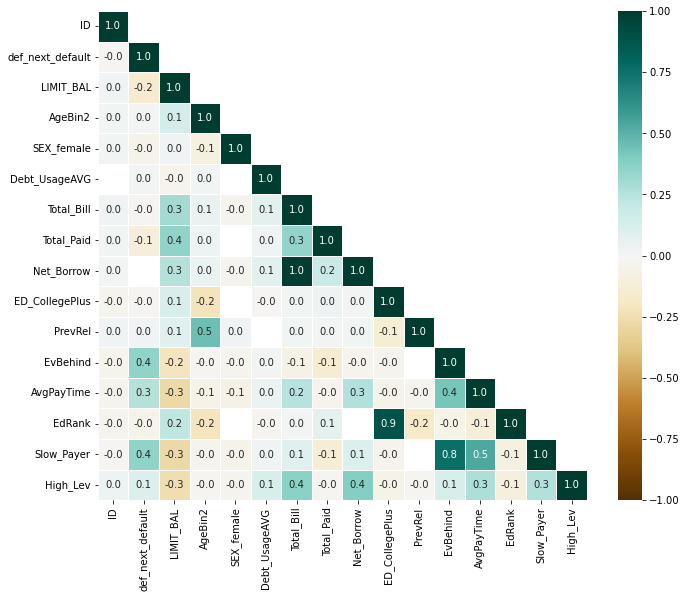

In [10]:
def corr_sig(df=Summary):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

def plot_cor_matrix(corr_sig, mask2):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                cmap="BrBG", annot=True, vmin=-1, vmax=1, center=0, mask=mask2,
                square=True, fmt=".1f", linewidths=.5)

p_values=corr_sig(Summary)
psig=.05
mask = np.invert(np.tril(p_values<psig))
plot_cor_matrix(p_values,mask)


In [11]:
## Multicollinearity Test
## Calls Previously Defined Functions

# All three methods drop Total_Bill and ED_CollegePlus

# "Final" feature list: [ID','def_next_default','LIMIT_BAL', 'AgeBin2', 
#'SEX_female', 'Debt_UsageAVG', 'Total_Paid', 'Net_Borrow', 'PrevRel', 'EvBehind', 'AvgPayTime', '
## EdRank', 'Slow_Payer', 'High_Lev'

X = Summary.copy()

##Method 1 
#X2 = calculate_vif_(X,5) # Actually running the function
#print(X2.info())

##Method 2
#X3=multicollinearity_check(X, thresh=5)
#print(X3.info())

##Method 3
X4=removeMultiColl(X, vif_threshold = 5.0)
#print(X4.info()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/mushambo/anaconda3/envs/UTDA_1/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    3.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    3.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    3.6s remaining:    0.8s
/home/mushambo/anaconda3/envs/UTDA_1/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/mushambo/anaconda3/envs/UTDA_1/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.8s finished
[

Dropping column : Total_Bill at index - 6


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


Dropping column : ED_CollegePlus at index - 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:    0.2s remaining:    0.2s


Remaining columns :
 ['ID', 'def_next_default', 'LIMIT_BAL', 'AgeBin2', 'SEX_female', 'Debt_UsageAVG', 'Total_Paid', 'Net_Borrow', 'PrevRel', 'EvBehind', 'AvgPayTime', 'EdRank', 'Slow_Payer', 'High_Lev']


[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s finished


Top Absolute Pairwise Correlations
EvBehind          Slow_Payer    0.764231
AvgPayTime        Slow_Payer    0.533682
AgeBin2           PrevRel       0.450593
EvBehind          AvgPayTime    0.422624
Net_Borrow        High_Lev      0.388128
def_next_default  Slow_Payer    0.357692
                  EvBehind      0.352858
LIMIT_BAL         Total_Paid    0.352655
                  AvgPayTime    0.275824
                  Slow_Payer    0.275668
dtype: float64


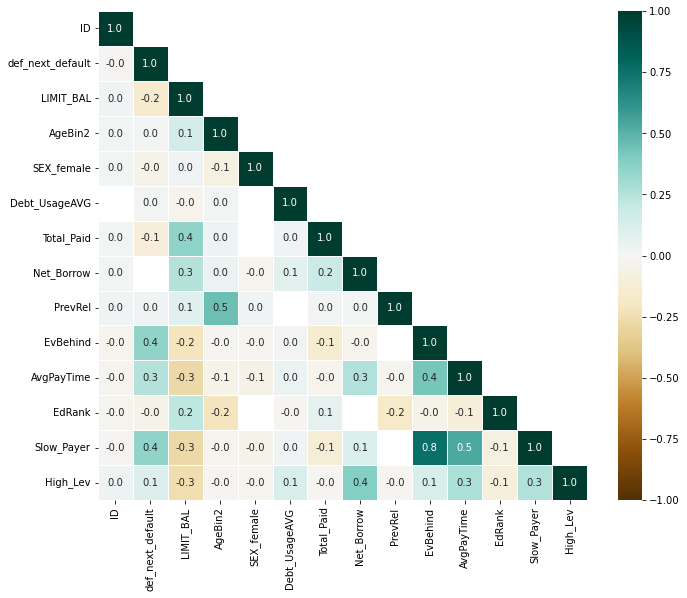

In [13]:
## Regraph Heatmap - Collinear features removed, Non significant pearsonr() p_value correlations whited out
## Might want to take out Net_Borrow as well, since it's not p<.05 pearsonr with def_next_default?
Summary = X4
corr=Summary.corr()
p_values=corr_sig(Summary)
psig=.05
mask = np.invert(np.tril(p_values<psig))
plot_cor_matrix(p_values,mask)

#Summary.corr().unstack().sort_values().drop_duplicates()

def get_top_abs_correlations(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Pairwise Correlations")
print(get_top_abs_correlations(Summary, 10))

#Summary.info() 

#### Masked (whited-out) cells in correlation heatmap above are not significant at p_value <.05
#### Focus on:

##### Top 10 Pairwise Correlations are:
Top Absolute Pairwise Correlations
AgeBin2           PrevRel       0.450593
EvBehind          AvgPayTime    0.422624
def_next_default  EvBehind      0.352858
LIMIT_BAL         Total_Paid    0.352655
                  AvgPayTime    0.275824 <-- Not sure why null, AvgPayTime:LIMIT_BAL has correlation of 0-.27
Net_Borrow        AvgPayTime    0.262049
LIMIT_BAL         Net_Borrow    0.256616
def_next_default  AvgPayTime    0.250756
LIMIT_BAL         EdRank        0.222762
AgeBin2           EdRank        0.214497

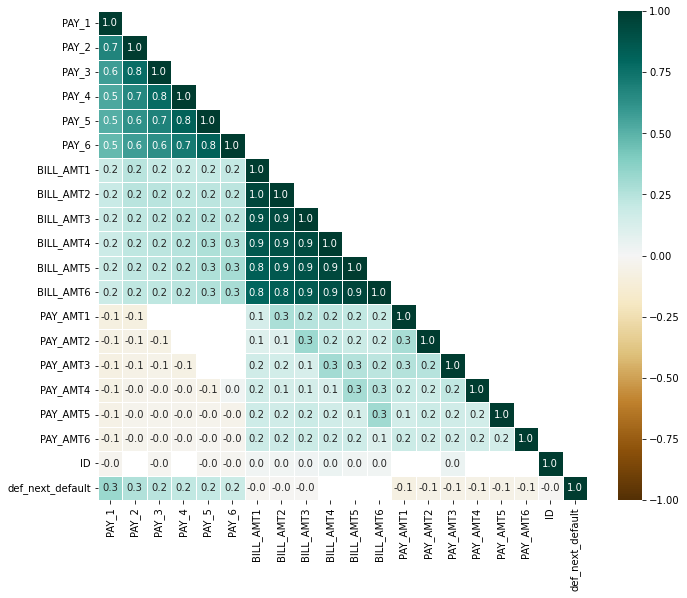

In [14]:
## Explore Correlation of Three Monthly Variables for Apr-Sept [columns*_1]
AprSep = data.loc[:,'PAY_1':'PAY_AMT6']
AprSep['ID']=data.loc[:,['ID']]
AprSep['def_next_default'] = data.loc[:,['def_next_default']]
corr=AprSep.corr()
p_values=corr_sig(AprSep)
psig=.05
mask = np.invert(np.tril(p_values<psig))
plot_cor_matrix(p_values,mask)

#### Primary Takeaways from Above correlation heatmap
#### PAY_AMT1 correlates best with BILL_AMT2 (~0.3), PAY_AMT2:BILL_AMT3 (same), etc. 
#### --> Sugests we SHOULD include time-series/shifting when analyzing delinquency 
#### Based solely on transaction (billing/payment) history, PAY_1 most correlates with prior PAY_ -- i.e., regularity matters more on whether customer makes recent month's payment moreso than monetary amounts billed/paid  

Monthly aggregate customer bills have increased from: 1166152812 to  1536699927 over the period
This is an increase of 0.3177517656236634 percent.

Monthly aggregate customer payments have increased from: 156465077 to  169907415 over the period
This is an increase of 0.08591270498016627 percent.
Customer average debt usage (calculated as Monthly Bill % of Limit) steadily increased over the period from 0.31858494825363615 to 0.42377145132492255

 This is an increase of 0.3301678363898847 percent
Credit One customers have gross outstanding credit limit of 5024529680


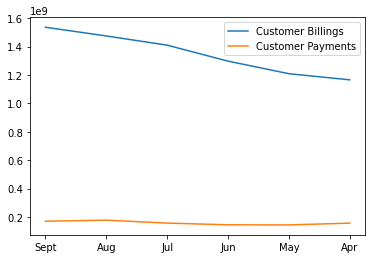

In [15]:
### Calculate Gross Amts Paid-Received In Each Period
Total_Bill=data.iloc[:,10:16].sum() ## Not what I intended to do, but this is total billed amount per period
Total_Paid=data.iloc[:,16:22].sum() ## Paid for each month

Monthly=['Sept','Aug','Jul','Jun','May','Apr']

## While customer bills have increased steadily, their payments have not followed suit, i.e. Credit One more exposed
sns.lineplot(x=Monthly, y=Total_Bill, data=Total_Bill, label='Customer Billings')
sns.lineplot(x=Monthly, y=Total_Paid, data=Total_Paid, label='Customer Payments')
print('Monthly aggregate customer bills have increased from:',Total_Bill[5],'to ',Total_Bill[0],'over the period')
print('This is an increase of',((Total_Bill[0]-Total_Bill[5])/Total_Bill[5]), 'percent.')
print('\nMonthly aggregate customer payments have increased from:',Total_Paid[5],'to ',Total_Paid[0],'over the period')
print('This is an increase of',((Total_Paid[0]-Total_Paid[5])/Total_Paid[5]), 'percent.')

print('Customer average debt usage (calculated as Monthly Bill % of Limit) steadily increased over the period from',
     data['Debt_Usage6'].mean(),'to',data['Debt_Usage1'].mean())
print('\n This is an increase of',(data['Debt_Usage1'].mean()-data['Debt_Usage6'].mean())/data['Debt_Usage6'].mean(),'percent')

print('Credit One customers have gross outstanding credit limit of',(data['LIMIT_BAL'].sum()))
#print((Total_Bill[5])/(data['LIMIT_BAL'].sum()))

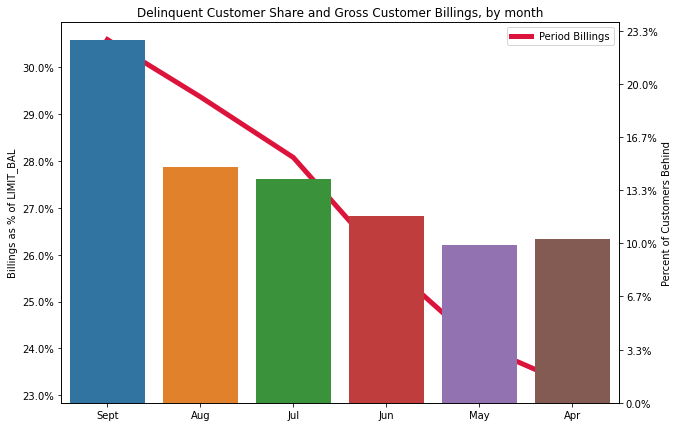

In [16]:
## Trending analysis of customers behind at least 1 month, for any given month

Monthly=['Sept','Aug','Jul','Jun','May','Apr']

MonthLate=pd.DataFrame(columns=Monthly)

MonthLate['Sept']=data.loc[data['Behind1'] == 1, ['Behind1']].value_counts()
MonthLate['Aug']=data.loc[data['Behind2'] == 1, ['Behind2']].value_counts()
MonthLate['Jul']= data.loc[data['Behind3'] == 1, ['Behind3']].value_counts()
MonthLate['Jun']=data.loc[data['Behind4'] == 1, ['Behind4']].value_counts()
MonthLate['May']=data.loc[data['Behind5'] == 1, ['Behind5']].value_counts()
MonthLate['Apr']=data.loc[data['Behind6'] == 1, ['Behind6']].value_counts()

#MonthLate.append(data['Behind1'].value_counts().astype(int)) ##6818 late
#MonthLate.append(data['Behind2'].value_counts().astype(int)) ##4438
#MonthLate.append(data['Behind3'].value_counts().astype(int))  ##4213
#MonthLate.append(data['Behind4'].value_counts().astype(int)) ##3510
#MonthLate.append(data['Behind5'].value_counts().astype(int)) ##2968 
#MonthLate.append(data['Behind6'].value_counts().astype(int)) ##3070 

MonthBill=[]

## Percent Billed Each Month as % of LIMIT_BAL

for i in [0,1,2,3,4,5]:
    MonthBill.append(Total_Bill[i]/(data['LIMIT_BAL'].sum()))
    #print(MonthBill)
    #print(MonthLate[i])

#print(pd.melt(MonthLate))
plt.figure(figsize=(10,7))
ax=sns.lineplot(x=Monthly, y=MonthBill, data=i, lw=5, color='crimson', label='Period Billings')
ax.axes.set_ylabel("Billings as % of LIMIT_BAL")
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax2=ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=30000))
ax2.axes.set_ylabel("Percent of Customers Behind")
ax2=sns.barplot(data=MonthLate)
plt.title("Delinquent Customer Share and Gross Customer Billings, by month")
plt.show()

#### CO's financial picture has worsened considerably in last six months
#### Share of customers behind in payments has doubled from 10% in APril to almost 25% in Sept
#### ALL customers (not just delinquents) are spending more, with monthly billings
#### Reaching over 30% of total LIMIT_BAL, up roughly a quarter vs. April's ~23% share

<AxesSubplot:xlabel='EdRank', ylabel='def_next_default'>

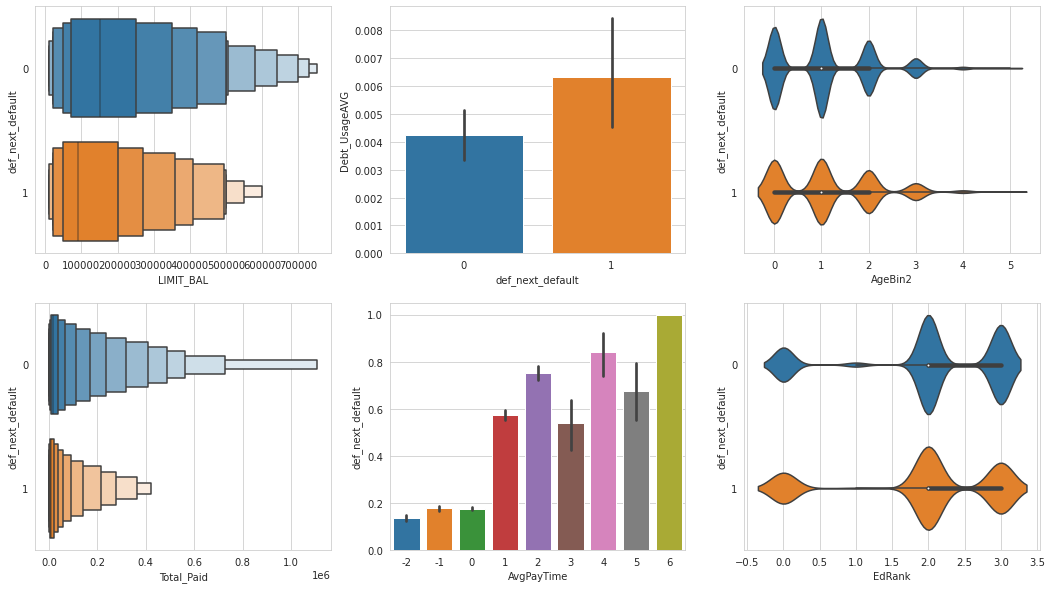

In [17]:
### Initial Grid layout 2rX3c
sns.reset_orig() ## Otherwise maintains non-sig pvalue mask from before
sns.set_style("whitegrid")
#Summary.info()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.boxenplot(ax=axes[0,0],data=Summary, x='LIMIT_BAL', y='def_next_default', orient="h",
             scale='linear', showfliers=False) ## Experiment with "exponential" and "area"
sns.boxenplot(ax=axes[1,0],data=Summary, x='Total_Paid', y='def_next_default', orient="h",
             scale='linear', showfliers=False)
sns.barplot(ax=axes[0,1],data=Summary, y='Debt_UsageAVG', x='def_next_default')
sns.barplot(ax=axes[1,1],data=Summary, x='AvgPayTime', y='def_next_default')
sns.violinplot(ax=axes[0,2],data=Summary, x='AgeBin2', y='def_next_default', orient="h")
sns.violinplot(ax=axes[1,2], data=Summary, x='EdRank', y='def_next_default', orient="h")
#sns.displot(ax=axes[0,2]), data=Summary, x='EdRank')
#sns.countplot(ax=axes[0,2]),data=Summary, x='AgeBin2', orient="h")
#sns.kdeplot(ax=axes[1,2]),data=Summary, x='EdRank', orient="h")
## Need to label but interesting to compare scales
#sea = sns.FacetGrid(Summary, col = "x", hue = "kind")

In [ ]:
## Trying to measure the range of a customer's payment codes
## Low range represents minimal change in payment patterns
## i.e., consistently on-time OR consistently 1 month late

PayRange=data.iloc[:,4:10]
print(PayRange.shape)

#print(data['PAY_1'].min()) ## PAY_1 code max is 8, min -2

for i in Range:
    CustRange=Range[i].std()
    Span=abs(Range[i].max())-abs(Range[i].min()) ## Not being calculated properly and cant traceback
    print(i,CustRange,Span) ## CustRange also not right - all 0 payments is stddev of 1.69 but all -1 is 0?

#data['Var_Payer'] = data['Pay_Variance'].ge(data['Pay_Variance'].quantile(thresh, interpolation="lower")).astype(int)

In [ ]:
##Seaborn Visualizations/Groupbys, and Findings THereof
##From Prior Submission, Focused on Exploring def_next_default status 
##May refer to prior dataframe names

##Defining InDefault as def_next_default ==1 and viceversa

#Age - Negligible Impact on Default Status
#sns.violinplot(x='def_next_default', y='AgeBin2', data=Summary) ## Possibly suggestive InDefault has more equal distribution?
#sns.boxplot(x='def_next_default', y='AgeBin2', data=Summary) ## No material difference in age b/w default status
#sns.stripplot(x='def_next_default', y=data['AGE'], data=Summary) ## Unclear effect
#sns.displot(data, x="AGE", hue="def_next_default", bins=15, element="step") ## Both distributions skew right
#print(data['AGE'].groupby(data['def_next_default']).describe()) #All quantiles almost identical for default status

#Education -- CIRCLE BACK
## Need percents and/or normalize against total counts of college incidence, b/c this suggests College Plus
## Or look into ordinal encoding of Education level?
#sns.catplot('def_next_default', hue='ED_CollegePlus', data=New, kind='count') 

#Gender - Those in Default are less likely to be female (0.567 vs. 0.614) but may not be stat. significant?
#sns.violinplot(x='def_next_default', y='SEX_female', data=New)
#sns.violinplot(x='SEX_female', y='def_next_default', data=New)
#print(New['SEX_female'].groupby(New['def_next_default']).describe())

#Limit_BAL - Those Not in Default have higher Limits overall 178K vs. 130K
#sns.boxplot(y='LIMIT_BAL', x='def_next_default', data=New, showfliers=False)
#print(New['LIMIT_BAL'].groupby(New['def_next_default']).describe())

#Debt_UsageAVG - Shows those defaulting indeed carry bills that are a larger share of total credit limit
#sns.boxplot(y='Debt_UsageAVG', x='def_next_default', data=New, showfliers=False)
#print(New['Debt_UsageAVG'].groupby(New['def_next_default']).describe())

#Net_Borrow - Almost identical Net_Borrow means for both segments, slightly more for Default
#sns.boxplot(y='Net_Borrow', x='def_next_default', data=New, showfliers=False)
#print(New['Net_Borrow'].groupby(New['def_next_default']).describe())

#AvgPayTime - Those Not in Default have sig. lower payment code (mean of -0.33 vs. 0.33; median of 0 vs. 0.33)
#sns.boxplot(y='AvgPayTime', x='def_next_default', data=New, showfliers=False)
#print(New['AvgPayTime'].groupby(New['def_next_default']).describe())

#EvBehind - Those in Default have mean of .64 vs. 0.24; Violin plot shows Non-defaults also fall behind on payments
#sns.violinplot(y=New['EvBehind'], x='def_next_default', data=New)
#print(New['EvBehind'].groupby(New['def_next_default']).describe())

#ED_CollegePlus - Those in Default have mean of .64 vs. 0.24; Violin plot shows Non-defaults also fall behind on payments
#sns.violinplot(y=New['ED_CollegePlus'], x='def_next_default', data=New)
#print(New['ED_CollegePlus'].groupby(New['def_next_default']).describe())

#Previous Relationship - Those in Default marginally more likely to have one..Mean 0.50 vs. 0.46
#sns.violinplot(y='PrevRel', x='def_next_default', data=New)
#print(New['PrevRel'].groupby(New['def_next_default']).describe())
#print(New['def_next_default'].groupby(New['PrevRel']).describe())

In [ ]:
### Basic ML Models to support zeroing in on which feature relationships to visualize further 

### Sets up loop of classification algorithms
algos_Class = []
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Decision Tree', DecisionTreeClassifier()))
algos_Class.append(('Extra Tree', ExtraTreeClassifier()))
algos_Class.append(('Bagging', BaggingClassifier()))
results = []
names = []

##Completely separate initial feature-set (X) & dependent variable (y) -- these change based on metric and 
X = Summary.loc[:,'LIMIT_BAL':'High_Lev'] 
y = Summary['def_next_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

for name, model in algos_Class:
    #pipe.fit(X_train,y_train)
    result = cross_val_score(model.fit(X_train,y_train), X_test, y_test, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
    
ytarg=0.0 
for i in range(len(names)):
    print(names[i],results[i].mean())
    ytarg += results[i].mean()
print("Average for Target Y", ytarg/(len(names))) ## Double check y matches desired target

In [ ]:
## Feature ID of Specific Models
## Method 1 (MDI) rates Total_Paid and Net_Borrow as having highest Feature Importance
## Method 2 (Permutation) rates EvBehind and AvgPayTime ""

forest=RandomForestClassifier(random_state=123)
feature_names=X.columns.values
#print(feature_names)

## RForest - Based on mean decrease in impurity
importances = forest.fit(X_train,y_train).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#forest_importances.nlargest(4).plot(kind='barh')

## RForest - Based on Permutation Importance
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
## Decision Tree
## Two leading features - Net_Borrow and Total_Paid
## Almost 2x that of Slow_Payer and LIMIT_BAL, 
## With all others trailing significantly

DTree=DecisionTreeClassifier(random_state=123).fit(X_train,y_train)
feat_importances = pd.DataFrame(DTree.feature_importances_, index=feature_names, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(32,24))
fig = plot_tree(DTree, feature_names=feature_names,filled=True,max_depth=3)
#text_representation = tree.export_text(DTree)
#print(text_representation)

## L1 splits on Slow_Payer <= 0.5, 
##L2 splits on EvBehind <= 0.5 & AvgPayTime <=0.5, 
## L3 Contains Total_Paid (2 nodes), LIMIT_BAL (1), and AvgPayTime (1)

In [ ]:
## Visual comparison of how scale method affects boxenplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.boxenplot(ax=axes[0,0],data=Summary, x='LIMIT_BAL', y='def_next_default', orient="h",
             scale='linear', showfliers=False) ## Experiment with "exponential" and "area"
sns.boxenplot(ax=axes[1,0],data=Summary, x='Total_Paid', y='def_next_default', orient="h",
             scale='linear', showfliers=False)
sns.boxenplot(ax=axes[0,1],data=Summary, x='LIMIT_BAL', y='def_next_default', orient="h",
             scale='exponential', showfliers=False)
sns.boxenplot(ax=axes[1,1],data=Summary, x='Total_Paid', y='def_next_default', orient="h",
             scale='exponential', showfliers=False)
sns.boxenplot(ax=axes[0,2],data=Summary, x='LIMIT_BAL', y='def_next_default', orient="h",
             scale='area', showfliers=False)
sns.boxenplot(ax=axes[1,2],data=Summary, x='Total_Paid', y='def_next_default', orient="h",
             scale='area', showfliers=False)

In [ ]:
##Seaborn Stylization Settings for Universal Use
sns.set_style("whitegrid")
#sns.color_palette("rocket", as_cmap=True)
#sns.color_palette("mako", as_cmap=True)
#sns.color_palette("BrBG", as_cmap=True)